In [45]:
audio_path = "/home/anna-huang/Projects/Nithya/GaMaDHaNi-dev/audio-examples/input.wav"

In [46]:
import matplotlib.pyplot as plt
import time


# torchcrepe

In [47]:
import torchcrepe

In [48]:
audio, sr = torchcrepe.load.audio(audio_path)

In [50]:
# convert audio to mono
if audio.shape[0] > 1:
    audio = audio.mean(axis=0, keepdim=True)

In [52]:
hop_length = int(0.01 * sr)
print(hop_length)

441


In [53]:
fmin = 80
fmax = 800

In [54]:
model = 'tiny'
device = 'cuda'

In [55]:
%time torch_pitch = torchcrepe.predict(audio, sr, model=model, device=device, hop_length=hop_length, fmin=fmin, fmax=fmax)


CPU times: user 575 ms, sys: 16 ms, total: 591 ms
Wall time: 425 ms


In [56]:
torch_pitch.shape

torch.Size([1, 394])

# crepe

In [57]:
import crepe
import librosa
import numpy as np
from hmmlearn import hmm

In [58]:
def predict_voicing(confidence):
    # https://github.com/marl/crepe/pull/26
    """
    Find the Viterbi path for voiced versus unvoiced frames.
    Parameters
    ----------
    confidence : np.ndarray [shape=(N,)]
        voicing confidence array, i.e. the confidence in the presence of
        a pitch
    Returns
    -------
    voicing_states : np.ndarray [shape=(N,)]
        HMM predictions for each frames state, 0 if unvoiced, 1 if
        voiced
    """
    # uniform prior on the voicing confidence
    starting = np.array([0.5, 0.5])

    # transition probabilities inducing continuous voicing state
    transition = np.array([[0.99, 0.01], [0.01, 0.99]])

    # mean and variance for unvoiced and voiced states
    means = np.array([[0.0], [1.0]])
    variances = np.array([[0.25], [0.25]])

    # fix the model parameters because we are not optimizing the model
    model = hmm.GaussianHMM(n_components=2)
    model.startprob_, model.covars_, model.transmat_, model.means_, \
    model.n_features = starting, variances, transition, means, 1

    # find the Viterbi path
    voicing_states = model.predict(confidence.reshape(-1, 1), [len(confidence)])

    return np.array(voicing_states)

def extract_pitch(audio, unvoice=True, sr=16000, frame_shift_ms=10, log=True):
    time, frequency, confidence, _ = crepe.predict(
      audio, sr=sr,
      viterbi=True,
      step_size=frame_shift_ms,
      verbose=0 if not log else 1)
    f0 = frequency
    # if unvoice:
    #   is_voiced = predict_voicing(confidence)
    #   frequency_unvoiced = frequency * is_voiced
    #   f0 = frequency_unvoiced

    return time, f0, confidence

In [59]:
audio, sr = librosa.load(audio_path, sr=None)

In [60]:
%time _, og_crepe_f0, _ = extract_pitch(audio, unvoice=True, sr=sr, frame_shift_ms=10, log=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 754ms/step
CPU times: user 2min 31s, sys: 826 ms, total: 2min 32s
Wall time: 10 s


In [61]:
og_crepe_f0.shape

(394,)

Plot both contours

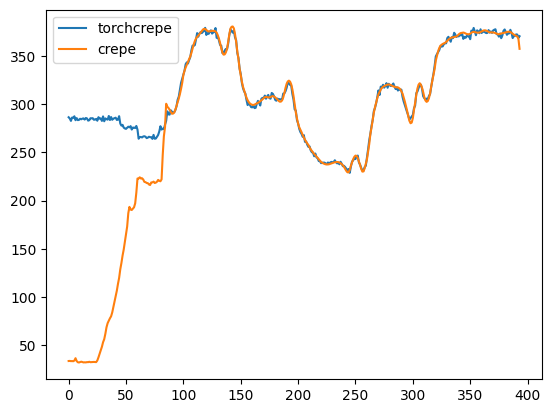

In [62]:
plt.plot(torch_pitch[0, :], label='torchcrepe')
plt.plot(og_crepe_f0, label='crepe')
plt.legend()

# Conclusion

There is a significant speedup with torch crepe (420ms vs 10s.). I think the smoothing with crepe does a better job with identifying unvoiced parts, but for the purpose of the app I don't think this is absolutely necessary since we can assume a fairly clean input